In [10]:
# --- Regenerate one cover by 成语 — call: regen_cover("画蛇添足") ---
%load_ext autoreload
%autoreload 2
import importlib, chengyu.cover_hybrid
importlib.reload(chengyu.cover_hybrid)

import os, io, re, json, subprocess
from pathlib import Path
from typing import Tuple
from PIL import Image
import yaml
from IPython.display import display, Image as IPImage

from chengyu.config import settings
from chengyu.cover_hybrid import generate_cover_hybrid

ROOT   = Path.cwd()
POSTS  = ROOT / "_posts"
EP_DIR = ROOT / "episodes"

# ---------- helpers ----------
def parse_front_matter(p: Path):
    t = p.read_text(encoding="utf-8")
    if not t.startswith("---"): return {}, t
    end = t.find("\n---", 3)
    if end == -1: return {}, t
    fm_text = t[4:end]
    body = t[end+4:];  body = body[1:] if body.startswith("\n") else body
    fm = yaml.safe_load(fm_text) or {}
    return fm, body

def write_front_matter(p: Path, fm: dict, body: str):
    p.write_text("---\n" + yaml.safe_dump(fm, allow_unicode=True, sort_keys=False) + "---\n\n" + body, encoding="utf-8")

def extract_chengyu_pinyin(title: str) -> Tuple[str, str]:
    m = re.match(r"\s*([^()（）]+?)\s*[\(（]([^)）]+)[\)）]\s*$", title or "")
    return (m.group(1).strip(), m.group(2).strip()) if m else ((title or "").strip(), "")

def read_story(folder_dir: Path) -> str:
    meta = folder_dir / "metadata.json"
    if meta.exists():
        try:
            d = json.loads(meta.read_text(encoding="utf-8"))
            s = d.get("script", "")
            if isinstance(s, str) and s.strip(): return s
        except Exception: pass
    tr = folder_dir / "transcript.txt"
    if tr.exists():
        try: return tr.read_text(encoding="utf-8")
        except Exception: pass
    return ""

def top_too_dark(img_bytes: bytes, frac: float = 0.18, lum_thresh: int = 35, max_ratio: float = 0.16) -> bool:
    im = Image.open(io.BytesIO(img_bytes)).convert("L")
    h = max(1, int(im.height * frac))
    roi = im.crop((0, 0, im.width, h))
    hist = roi.histogram()
    dark = sum(hist[:max(0, lum_thresh)])
    total = roi.width * roi.height
    return (dark / max(1, total)) > max_ratio

def git(*args):
    print("+ git", " ".join(args))
    subprocess.check_call(["git", *args], cwd=ROOT)

def find_posts_by_chengyu(q: str):
    out = []
    for md in sorted(POSTS.glob("*.md")):
        fm, _ = parse_front_matter(md)
        if q in (fm.get("title","")):
            out.append((md, fm))
    return out

def show_current_cover(epdir: Path):
    for name in ("cover.jpg", "cover.jpeg", "cover.png"):
        p = epdir / name
        if p.exists():
            print("Current cover:", p)
            display(IPImage(filename=str(p)))
            break

# ---------- main API you call ----------
def regen_cover(chengyu_query: str, attempts: int = 4, commit: bool = True,
                pinyin_y: float = 0.50, english_y: float = 0.78) -> Path:
    """Regenerate cover for the most recent post whose title contains the given 成语."""
    matches = find_posts_by_chengyu(chengyu_query)
    if not matches:
        raise RuntimeError(f"No post title contains: {chengyu_query}")

    md, fm = matches[-1]  # most recent
    date = md.name[:10]; slug = md.stem[11:]; folder = f"{date}-{slug}"
    epdir = EP_DIR / folder
    if not epdir.exists():
        raise RuntimeError(f"Missing episode folder: episodes/{folder}")

    title = fm.get("title",""); desc = fm.get("description","")
    ch, py = extract_chengyu_pinyin(title)
    story = read_story(epdir)

    print(f"→ Regenerating: {ch} ({py})  [{folder}]")
    show_current_cover(epdir)

    cover = None
    for i in range(1, attempts+1):
        print(f"Attempt {i}/{attempts} …")
        cover = generate_cover_hybrid(
            chengyu=ch, pinyin=py, english=desc, story=story,
            model=getattr(settings,"IMAGE_MODEL","gpt-image-1"),
            size=getattr(settings,"IMAGE_SIZE","1024x1024"),
            quality="medium", out_size=1500, out_format="JPEG",
            pinyin_y=pinyin_y, english_y=english_y
        )
        if not top_too_dark(cover):
            break
        print("  (Top looks too dark; retrying…)")

    out_path = epdir / "cover.jpg"
    out_path.write_bytes(cover)
    print("✔ Wrote", out_path)
    display(IPImage(data=cover))

    desired_rel = f"/episodes/{folder}/cover.jpg"
    if fm.get("cover_image") != desired_rel:
        _, body = parse_front_matter(md)
        fm["cover_image"] = desired_rel
        write_front_matter(md, fm, body)
        print("✔ Updated cover_image in", md)

    if commit:
        try:
            git("add", str(out_path.relative_to(ROOT)), str(md.relative_to(ROOT)))
            git("commit", "-m", f"Regenerate cover for {ch}")
            git("push", "origin", "main")
            print("✔ Pushed")
        except subprocess.CalledProcessError as e:
            print("⚠️ Git push failed (push manually):", e)

    return out_path


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


→ Regenerating: 三心二意 (sān xīn èr yì)  [2025-08-28-san-xin-er-yi]
Current cover: /Users/tilman/github3/chengyudaily/episodes/2025-08-28-san-xin-er-yi/cover.jpg


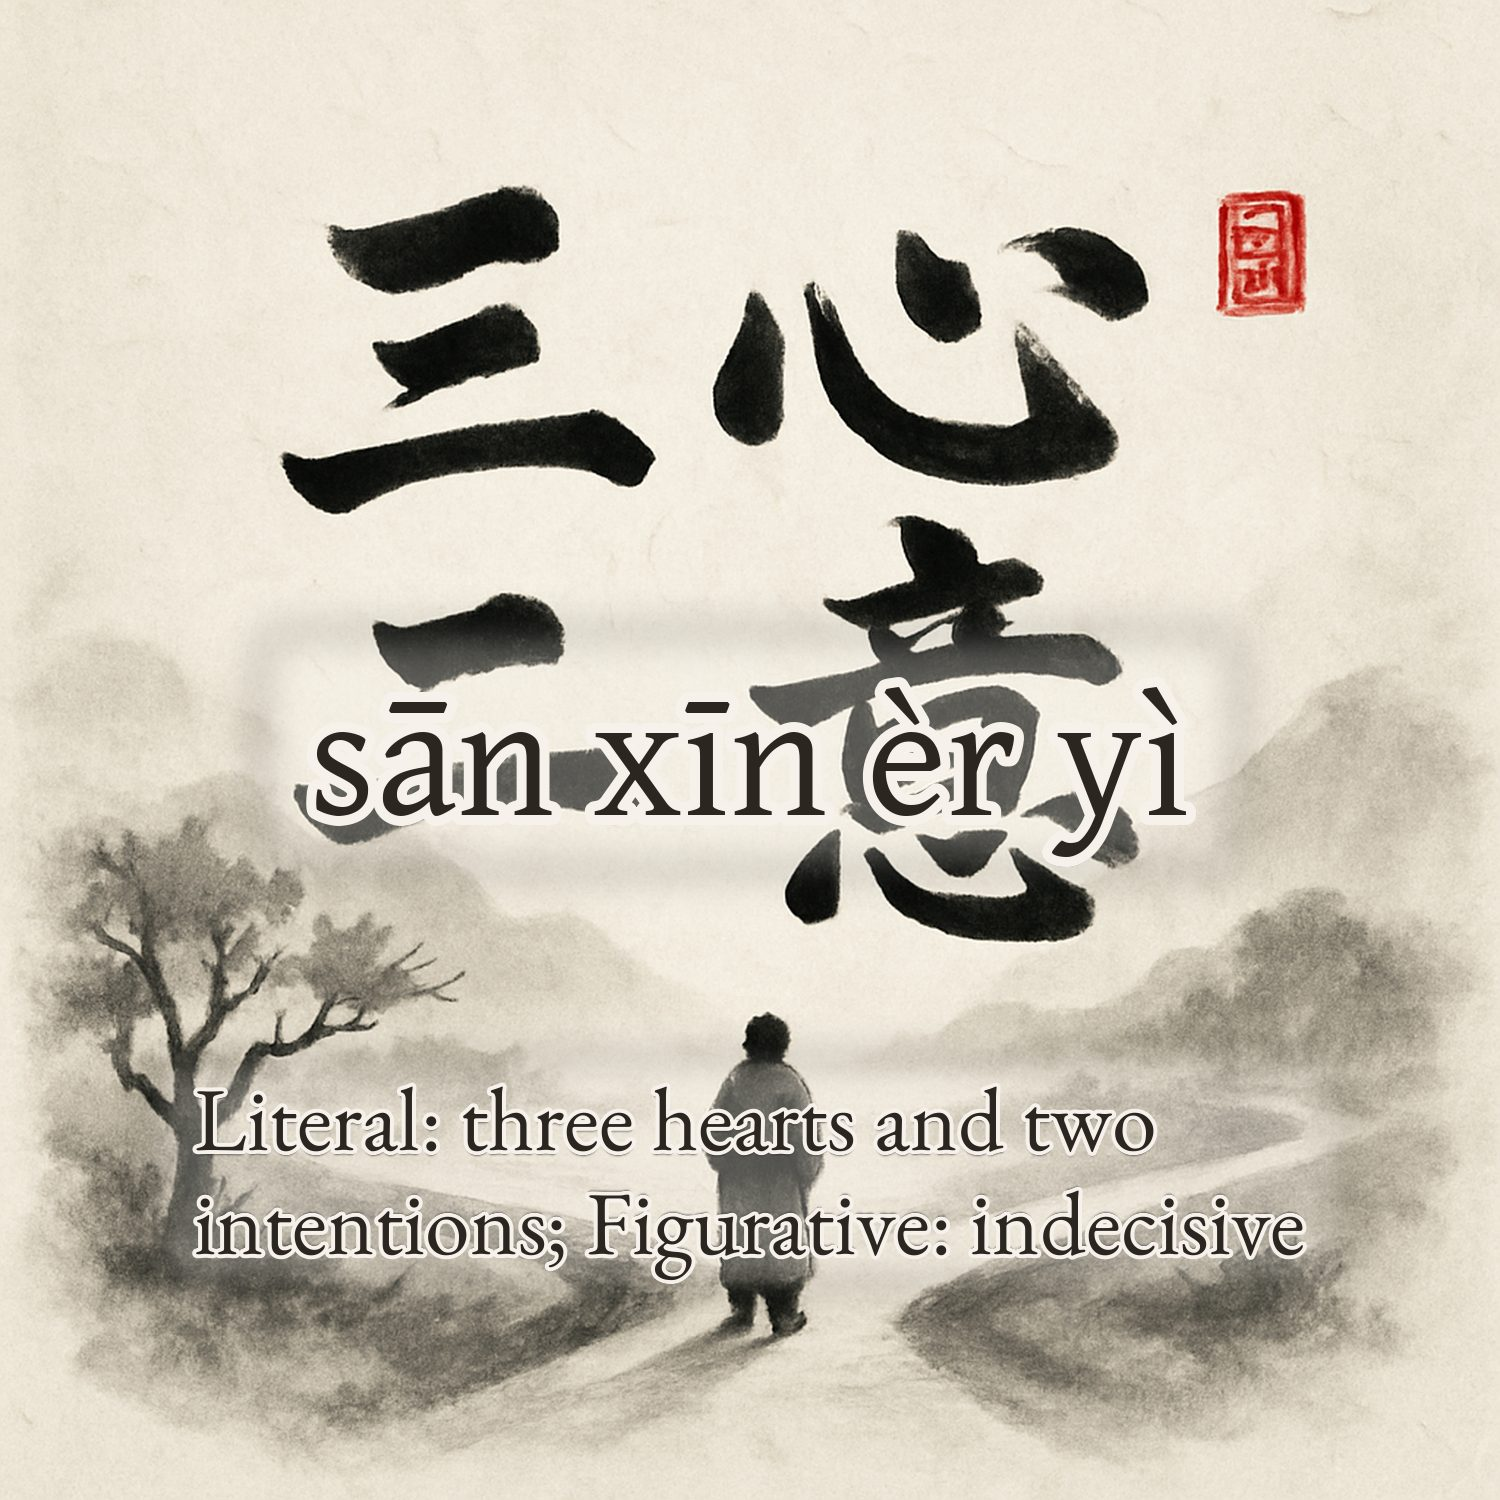

Attempt 1/4 …
✔ Wrote /Users/tilman/github3/chengyudaily/episodes/2025-08-28-san-xin-er-yi/cover.jpg


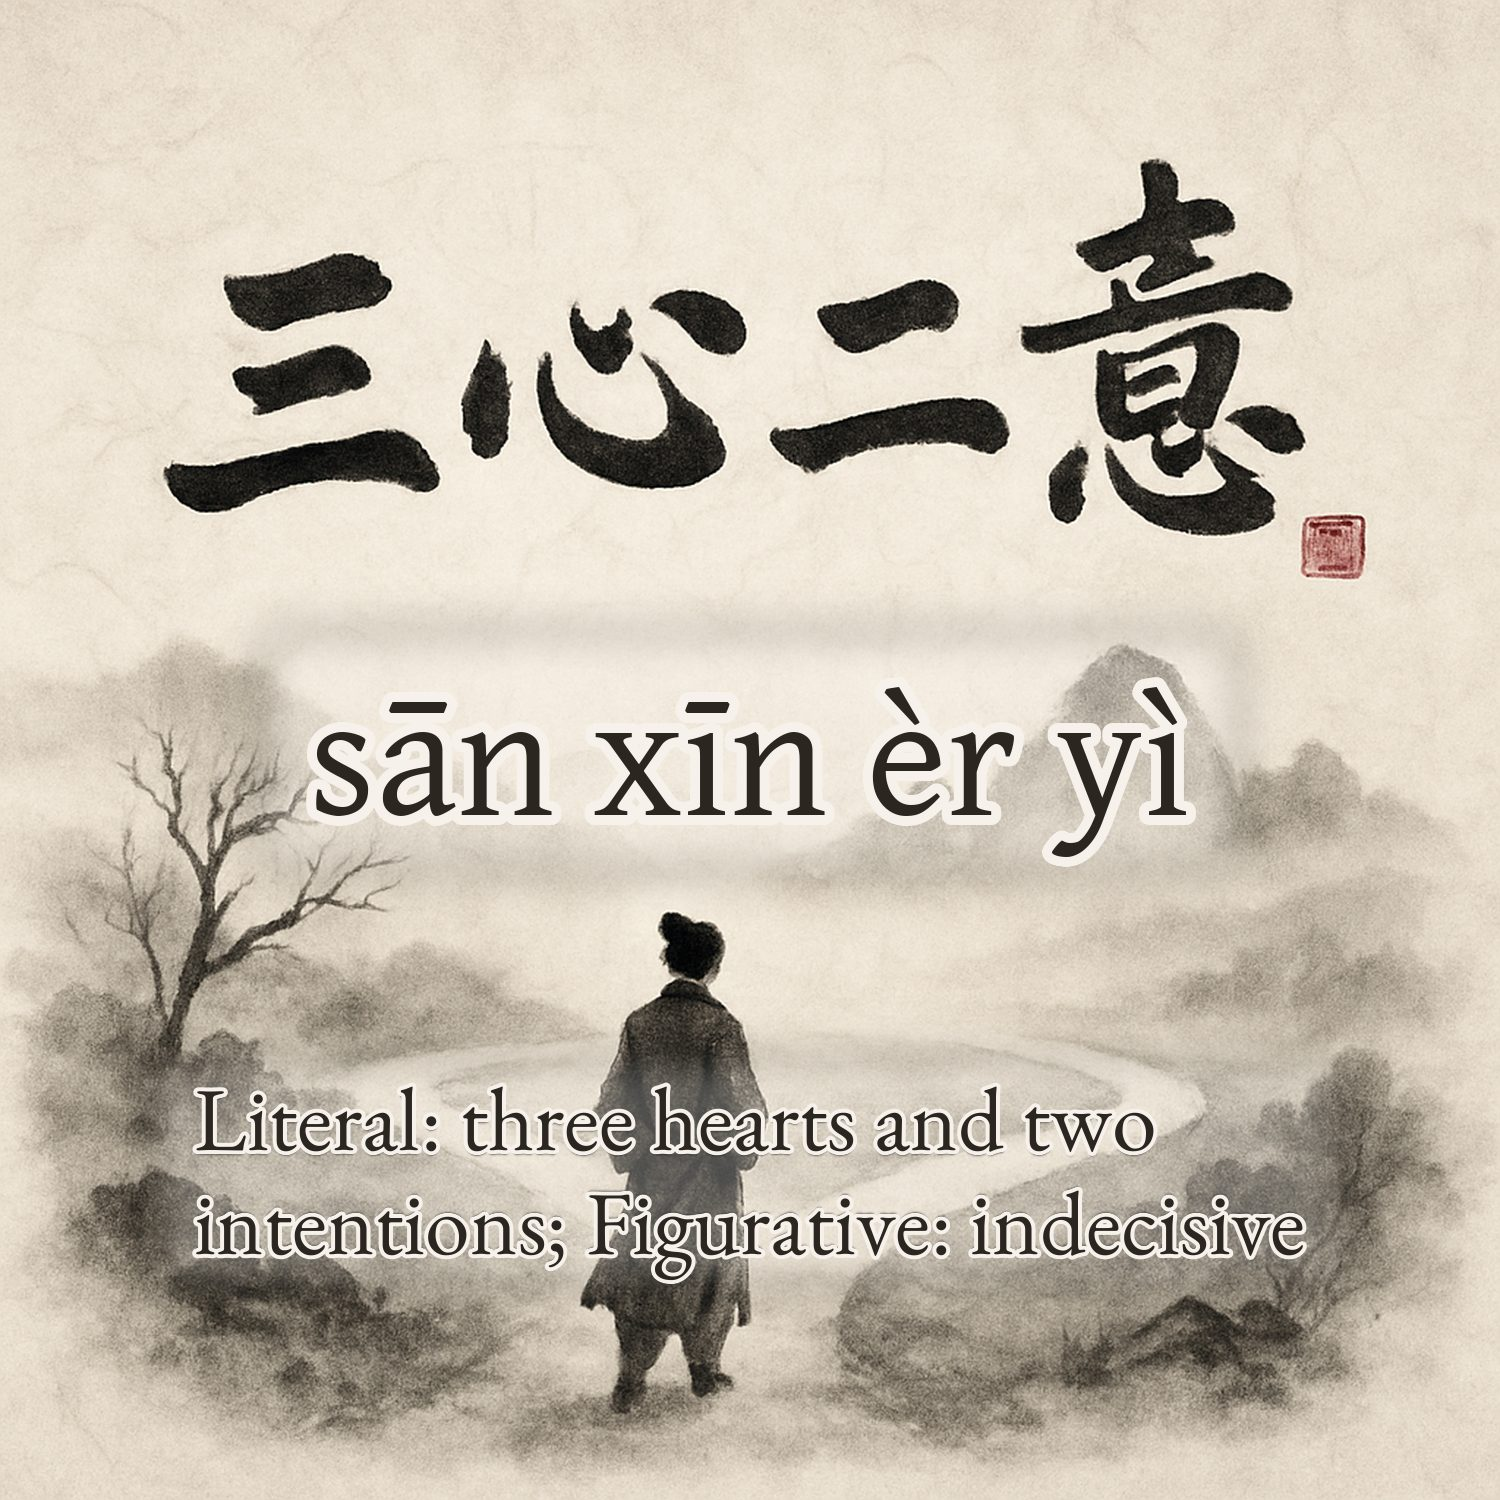

+ git add episodes/2025-08-28-san-xin-er-yi/cover.jpg _posts/2025-08-28-san-xin-er-yi.md
+ git commit -m Regenerate cover for 三心二意
[main be6551e] Regenerate cover for 三心二意
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite episodes/2025-08-28-san-xin-er-yi/cover.jpg (95%)
+ git push origin main
✔ Pushed


To https://github.com/kohlenberg/chengyudaily.git
   bc414db..be6551e  main -> main


PosixPath('/Users/tilman/github3/chengyudaily/episodes/2025-08-28-san-xin-er-yi/cover.jpg')

In [13]:
regen_cover("三心二意")          # regenerate that one
